In [ ]:
!pip install imblearn --quiet
!pip install tensorflow --quiet

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from torch.nn import CrossEntropyLoss
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input # Import the Input object
from tensorflow.keras.models import Model # Import the Model object
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Import google drive where dataset is stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv_file = "/content/drive/MyDrive/Colab_Notebooks1/investigator_nacc63.csv"
df = pd.read_csv(csv_file, low_memory=False)

#**Data Processing**

In [ ]:
def preprocess_dataset(df, target_column):
    """
    Preprocessing dataset for the neural network models.

    Args:
        df: The pandas DataFrame containing the data.
        target_column: The name of the target variable.

    Returns:
        df: The updated DataFrame with preprocessed data.
    """
    # Handle `-4` as missing value
    df.replace(-4, np.nan, inplace=True)

    # Handle infinite and missing values in numerical columns
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numerical_columns] = df[numerical_columns].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Identify categorical columns (excluding the target column, unique IDs, and class_description)
    categorical_cols = [
        col for col in df.select_dtypes(include=['object', 'category']).columns
        if col != 'NACCID' and col != target_column and col != 'class_description'
    ]

    # Handle missing values for categorical columns and encode them
    for col in categorical_cols:
        df[col] = df[col].fillna('missing')  # Replace NaN with a placeholder
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))  # Encode as integers

    # Hash the NACCID column and concatenate all changes at once
    if 'NACCID' in df.columns:
        # Apply hash function and create a new DataFrame for hashed values
        hashed_ids = df['NACCID'].apply(lambda x: int(hash(x) % (10**9))).to_frame('hashed_NACCID')
        df = pd.concat([df, hashed_ids], axis=1)  # Concatenate the hashed IDs with the original DataFrame
        df.drop(columns=['NACCID'], inplace=True)  # Drop the original NACCID column

    # Mapping for the target variable
    class_mapping = {
        1: 0,  # Normal cognition
        2: 1,  # Impaired-not-MCI
        3: 2,  # MCI
        4: 3   # AD
    }
    class_descriptions = {
        0: 'Normal cognition',
        1: 'Impaired-not-MCI',
        2: 'MCI',
        3: 'AD'
    }

    # Add a column with the original class descriptions
    df['class_description'] = df[target_column].map(class_mapping).map(class_descriptions)

    # Map the target column to numeric labels
    df[target_column] = df[target_column].map(class_mapping)

    # Check for unmapped or missing target values
    if df[target_column].isnull().any():
        raise ValueError(
            f"Target column '{target_column}' contains unmapped or missing values. Ensure all classes are included in the mapping."
        )

    # Confirm that no columns (excluding 'class_description') have 'object' or 'category' dtype remaining
    categorical_cols_to_check = [col for col in df.columns if col != 'class_description']
    if any(dtype in ['object', 'category'] for dtype in df[categorical_cols_to_check].dtypes.values):
        raise ValueError("Some categorical columns (excluding 'class_description') are still of object or category dtype. Ensure all are encoded.")

    return df

# Apply function
df = preprocess_dataset(df, 'NACCUDSD')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183097 entries, 0 to 183096
Columns: 1025 entries, NACCADC to class_description
dtypes: float64(734), int64(290), object(1)
memory usage: 1.4+ GB


#**Data analysis and exploration to determine threshold for sequential feature**

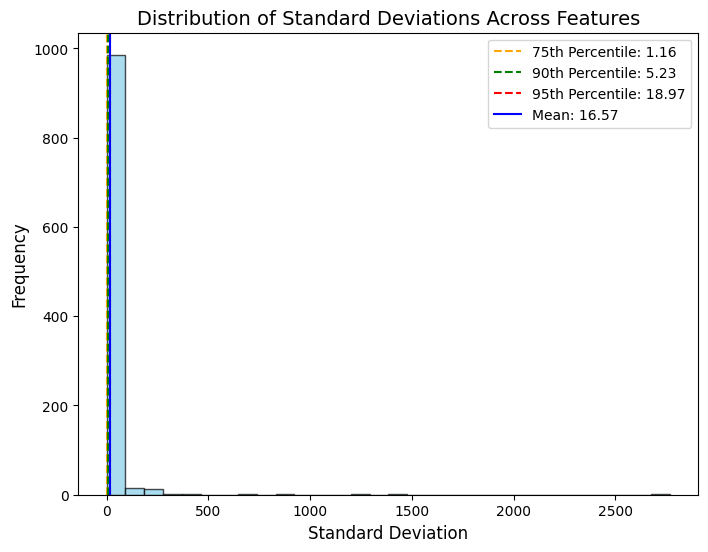

75th Percentile: 1.1592305635951683
90th Percentile: 5.231969657449739
95th Percentile: 18.974334215908577


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_std_distribution(df, participant_id_column, time_column):
    """
    Analyse standard deviation distribution of numeric features across participants.

    Args:
        df: Input DataFrame.
        participant_id_column: Column indicating participant ID.
        time_column: Column indicating visit number.

    Returns:
        std_values: Dictionary of standard deviations for each numeric feature.
        numeric_cols: List of numeric columns analyzed.
        percentiles: Dictionary containing the 75th, 90th, and 95th percentiles.
    """
    # Sort by participant and time columns
    df = df.sort_values(by=[participant_id_column, time_column]).reset_index(drop=True)

    # Select numeric columns, excluding participant ID and time columns
    numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns
                    if col not in [participant_id_column, time_column]]

    # Group by participant and calculate standard deviations
    groups = df.groupby(participant_id_column)
    std_values = {col: groups[col].std().mean() for col in numeric_cols}

    # Calculate the percentiles for standard deviations
    std_list = list(std_values.values())
    percentile_75 = np.percentile(std_list, 75)
    percentile_90 = np.percentile(std_list, 90)
    percentile_95 = np.percentile(std_list, 95)

    # Plot histogram of standard deviations
    plt.figure(figsize=(8, 6))
    plt.hist(std_list, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Distribution of Standard Deviations Across Features", fontsize=14)
    plt.xlabel("Standard Deviation", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

    # Plot vertical lines for percentiles
    plt.axvline(x=percentile_75, color='orange', linestyle='--', label=f'75th Percentile: {percentile_75:.2f}')
    plt.axvline(x=percentile_90, color='green', linestyle='--', label=f'90th Percentile: {percentile_90:.2f}')
    plt.axvline(x=percentile_95, color='red', linestyle='--', label=f'95th Percentile: {percentile_95:.2f}')

    # Add mean line
    mean_std = np.mean(std_list)
    plt.axvline(x=mean_std, color='blue', linestyle='-', label=f'Mean: {mean_std:.2f}')

    # Add legend
    plt.legend(loc='upper right')

    # Display the plot
    plt.show()

    # Return the std values, numeric columns, and percentiles
    percentiles = {
        '75th_percentile': percentile_75,
        '90th_percentile': percentile_90,
        '95th_percentile': percentile_95
    }

    return std_values, numeric_cols, percentiles

# Function call
std_values, numeric_cols, percentiles = analyze_std_distribution(
    df,
    participant_id_column='hashed_NACCID',
    time_column='NACCVNUM'
)

# Now, you can dynamically access percentiles like this:
print(f"75th Percentile: {percentiles['75th_percentile']}")
print(f"90th Percentile: {percentiles['90th_percentile']}")
print(f"95th Percentile: {percentiles['95th_percentile']}")


In [ ]:
# downcasting of data types for memeory efficiency

# Identify and downcast suitable columns before preprocessing
for column in df.select_dtypes(include=['int64']).columns:
    if df[column].max() < np.iinfo(np.int32).max and df[column].min() > np.iinfo(np.int32).min:
        df[column] = df[column].astype('int32')
    elif df[column].max() < np.iinfo(np.int16).max and df[column].min() > np.iinfo(np.int16).min:
        df[column] = df[column].astype('int16')

for column in df.select_dtypes(include=['float64']).columns:
    df[column] = df[column].astype('float32')



In [ ]:
print(df[numeric_cols].dtypes)  # Check before processing

NACCADC       int32
PACKET        int32
FORMVER     float32
VISITMO       int32
VISITDAY      int32
             ...   
NPATGFRN    float32
NPATGFR1    float32
NPATGFR2    float32
NPATGFR3    float32
NPATGFR4    float32
Length: 1022, dtype: object


#**Identify sequential features for LSTM**

In [ ]:
def identify_sequential_features(
    df, participant_id_column, time_column, target_column, percentiles
):
    """
    Automatically identify sequential features by checking variability across visits.

    Args:
        df: Input DataFrame.
        participant_id_column: Column indicating participant ID.
        time_column: Column indicating visit number.
        percentiles: Dictionary containing percentiles for variability thresholds (e.g., 90th, 95th).

    Returns:
        sequential_features: List of identified sequential feature columns.
    """
    # Select numeric columns, excluding participant ID, time column, and target column
    numeric_cols = [
        col for col in df.select_dtypes(include=['float64', 'int64', 'int32', 'float32']).columns
        if col not in [participant_id_column, time_column, target_column, 'class_description']
    ]

    sequential_features = []

    # Extract the dynamic threshold (90th percentile)
    threshold = percentiles['90th_percentile']

    # Group by participant and calculate variability for each feature
    groups = df.groupby(participant_id_column)
    for col in numeric_cols:
        # Compute standard deviation across visits for each participant
        std_per_participant = groups[col].std()

        # Check if the feature exceeds the threshold for variability (90th percentile)
        if (std_per_participant > threshold).any():
            sequential_features.append(col)

    # Ensure only numeric features are selected
    sequential_features = [
        col for col in sequential_features if col in df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
    ]

    # Print and return the identified sequential features
    print(f"Identified Sequential Features (Threshold={threshold}): {sequential_features}")
    return sequential_features


In [ ]:
# Calling the function
sequential_features = identify_sequential_features(
    df=df,
    participant_id_column='hashed_NACCID',  # Participant ID column
    time_column='NACCVNUM',                 # time column
    target_column='NACCUDSD',               # Target column
    percentiles=percentiles,                # Set an appropriate threshold
)

Identified Sequential Features (Threshold=5.231969657449739): ['NACCADC', 'VISITMO', 'VISITDAY', 'VISITYR', 'NACCDAYS', 'NACCFDYS', 'BIRTHYR', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'INBIRMO', 'INBIRYR', 'INHISP', 'INHISPOR', 'INHISPOX', 'NACCNINR', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX', 'INRATER', 'INRATERX', 'INEDUC', 'INRELTOX', 'INKNOWN', 'INVISITS', 'INCALLS', 'DRUG1', 'DRUG2', 'DRUG3', 'DRUG4', 'DRUG5', 'DRUG6', 'DRUG7', 'DRUG8', 'DRUG9', 'DRUG10', 'DRUG11', 'DRUG12', 'DRUG13', 'DRUG14', 'DRUG15', 'DRUG16', 'DRUG17', 'DRUG18', 'DRUG19', 'DRUG20', 'DRUG21', 'DRUG22', 'DRUG23', 'DRUG24', 'DRUG25', 'DRUG26', 'DRUG27', 'DRUG28', 'DRUG29', 'DRUG30', 'DRUG31', 'DRUG32', 'DRUG33', 'DRUG34', 'DRUG35', 'TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER', 'QUITSMOK', 'ALCOCCAS', 'ALCFREQ', 'CVHATT', 'HATTMULT', 'HATTYEAR', 'CVAFIB', 'CVANGIO', 'CVBYPASS', 'CVPACDEF', 'CVPACE', 'CVCHF', 'CVANGINA', 'CVHVALVE', 'CVOTHR', 'CVOTHRX', 'CBSTROKE', 'STROKMUL', 'CBTIA', 'TIAMULT', 'PD', 'PD

In [ ]:
print(sequential_features)
print(df[sequential_features].dtypes)

['NACCADC', 'VISITMO', 'VISITDAY', 'VISITYR', 'NACCDAYS', 'NACCFDYS', 'BIRTHYR', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'INBIRMO', 'INBIRYR', 'INHISP', 'INHISPOR', 'INHISPOX', 'NACCNINR', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX', 'INRATER', 'INRATERX', 'INEDUC', 'INRELTOX', 'INKNOWN', 'INVISITS', 'INCALLS', 'DRUG1', 'DRUG2', 'DRUG3', 'DRUG4', 'DRUG5', 'DRUG6', 'DRUG7', 'DRUG8', 'DRUG9', 'DRUG10', 'DRUG11', 'DRUG12', 'DRUG13', 'DRUG14', 'DRUG15', 'DRUG16', 'DRUG17', 'DRUG18', 'DRUG19', 'DRUG20', 'DRUG21', 'DRUG22', 'DRUG23', 'DRUG24', 'DRUG25', 'DRUG26', 'DRUG27', 'DRUG28', 'DRUG29', 'DRUG30', 'DRUG31', 'DRUG32', 'DRUG33', 'DRUG34', 'DRUG35', 'TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER', 'QUITSMOK', 'ALCOCCAS', 'ALCFREQ', 'CVHATT', 'HATTMULT', 'HATTYEAR', 'CVAFIB', 'CVANGIO', 'CVBYPASS', 'CVPACDEF', 'CVPACE', 'CVCHF', 'CVANGINA', 'CVHVALVE', 'CVOTHR', 'CVOTHRX', 'CBSTROKE', 'STROKMUL', 'CBTIA', 'TIAMULT', 'PD', 'PDYR', 'PDOTHR', 'PDOTHRYR', 'SEIZURES', 'NACCTBI', 'TBI', 'TBIB

In [ ]:
# check if sequential_features contains the following columns'hashed_NACCID', 'NACCVNUM', 'NACCUDSD', 'class_description'
print('hashed_NACCID' in sequential_features)
print('NACCVNUM' in sequential_features)
print('NACCUDSD' in sequential_features)
print('class_description' in sequential_features)

False
False
False
False


In [ ]:
# Define columns to exclude from non-sequential features
excluded_columns = sequential_features + ['hashed_NACCID', 'NACCVNUM', 'NACCUDSD', 'class_description']  # Add other irrelevant columns as needed

# Identify remaining features not in sequential_features or excluded columns
non_sequential_features = [col for col in df.columns if col not in excluded_columns]

# Print the number of non-sequential features
print(f"Total Non-Sequential Features: {len(non_sequential_features)}")
print(f"Sample Non-Sequential Features: {non_sequential_features[:10]}")  # Display first 10 features

Total Non-Sequential Features: 427
Sample Non-Sequential Features: ['PACKET', 'FORMVER', 'NACCAVST', 'NACCNVST', 'NACCCORE', 'NACCREAS', 'NACCREFR', 'BIRTHMO', 'SEX', 'HISPANIC']


In [ ]:
# check how many non_sequential_features are in sequential_features
print(len(set(non_sequential_features) & set(sequential_features)))

0


In [ ]:
print('hashed_NACCID' in non_sequential_features)
print('NACCVNUM' in non_sequential_features)
print('NACCUDSD' in non_sequential_features)
print('class_description' in non_sequential_features)

False
False
False
False


In [ ]:
# Set correlation threshold
correlation_threshold = 0.85

# Copy of features for iterative pruning
remaining_features = non_sequential_features.copy()

# Compute initial correlation matrix
corr_matrix = df[remaining_features].corr().abs()

while True:
    # Select the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find the strongest correlation
    max_corr = upper_triangle.max().max()

    if max_corr < correlation_threshold:
        # Stop if no correlations exceed the threshold
        break

    # Identify the pair of features with the strongest correlation
    to_drop = upper_triangle.stack().idxmax()[1]  # Drop 'Feature_2' from the strongest pair

    # Remove the feature from the remaining features
    remaining_features.remove(to_drop)

    # Drop the feature from the correlation matrix
    corr_matrix = corr_matrix.loc[remaining_features, remaining_features]

# Final filtered DataFrame
df_non_sequential_filtered = df[remaining_features]

# Print the features that were not eliminated
print("Features retained after pruning:")
print(remaining_features)

Features retained after pruning:
['PACKET', 'FORMVER', 'NACCAVST', 'NACCCORE', 'NACCREAS', 'NACCREFR', 'BIRTHMO', 'SEX', 'HISPANIC', 'HISPOR', 'HISPORX', 'RACE', 'RACEX', 'RACESEC', 'RACESECX', 'RACETER', 'RACETERX', 'PRIMLANG', 'PRIMLANX', 'EDUC', 'HANDED', 'INSEX', 'NEWINF', 'INRELTO', 'INLIVWTH', 'INRELY', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCAM', 'NACCAMX', 'NACCOMSX', 'NACCFADM', 'NACCFFTD', 'ANYMEDS', 'DRUG36', 'DRUG37', 'DRUG38', 'DRUG39', 'NACCSTYR', 'NACCTIYR', 'ABRUPT', 'STEPWISE', 'SOMATIC', 'EMOT', 'HXHYPER', 'HXSTROKE', 'FOCLSYM', 'FOCLSIGN', 'NPIQINF', 'NOGDS', 'NORMEXAM', 'PARKSIGN', 'CVDSIGNS', 'POSTCORT', 'PSPCBS', 'ALSFIND', 'GAITNPH', 'OTHNEUR', 'B9CHG', 'DECCLIN', 'DECCLCOG', 'DECCLBE', 'BEOTHR', 'DECCLMOT', 'LBDEVAL', 'FTLDEVAL', 'MMSECOMP', 'MMSELOC', 'MMSELAN', 'MMSEVIS', 'MMSEHEAR', 'NPSYCLOC', 'NPSYLAN', 'COGSTAT', 'NACCC1', 'MOCACOMP', 'MOCAVIS', 'MOCAHEAR', 'CRAFTCUE', 'NACCC2', 'MODCOMM', 'RESPHEAR', 'RESPDIST', 'RESPINTR', 'RESPDISN', 'RESPFATG', 'RESPEMOT

In [ ]:
df_non_sequential_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183097 entries, 0 to 183096
Columns: 270 entries, PACKET to NPATGFR1
dtypes: float32(179), int32(91)
memory usage: 188.6 MB


#**Building the Model**

##**Preprocessing Sequential data**

In [ ]:
def sort_sequential_data(df, participant_id_column, time_column, sequential_features, df_non_sequential_filtered, target_column):
    """
    Sort sequential data by participant ID and time.

    Args:
        df: The pandas DataFrame containing the sequential data.
        participant_id_column: Column indicating participant ID.
        time_column: Column indicating visit number.
        sequential_features: List of sequential feature columns.
        non_sequential_features: List of non-sequential feature columns.
        target_column: The name of the target variable column.

    Returns:
        sorted_seq_data: The sorted sequential data.
    """


    seq_data = df[[participant_id_column, time_column] + sequential_features + non_sequential_features + [target_column]]
    sorted_seq_data = seq_data.sort_values(by=[participant_id_column, time_column]).reset_index(drop=True)
    return sorted_seq_data
participant_id_column = 'hashed_NACCID'  # Define participant_id_column
time_column = 'NACCVNUM'                # Define time_column
target_column = 'NACCUDSD'              # Define target_column
sorted_seq_data = sort_sequential_data(df, participant_id_column, time_column, sequential_features, df_non_sequential_filtered, target_column)

In [ ]:
def split_sequential_data_by_participants(sorted_seq_data, participant_id_column, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split sequential data into training, validation, and test sets by participants.

    Args:
        sorted_seq_data: The sorted sequential data.
        participant_id_column: Column indicating participant ID.
        train_ratio: Ratio for training set.
        val_ratio: Ratio for validation set.
        test_ratio: Ratio for test set.

        Returns:
        train_seq: Training set.
        val_seq: Validation set.
        test_seq: Test set.
    """
    # Get unique participant IDs and shuffle them
    participant_ids = sorted_seq_data[participant_id_column].unique()  # Get unique participant IDs
    np.random.seed(42)
    np.random.shuffle(participant_ids)
    num_participants = len(participant_ids)
    train_end = int(train_ratio * num_participants)
    val_end = train_end + int(val_ratio * num_participants)
    train_ids = participant_ids[:train_end]
    val_ids = participant_ids[train_end:val_end]
    test_ids = participant_ids[val_end:]
    train_seq = sorted_seq_data[sorted_seq_data[participant_id_column].isin(train_ids)].reset_index(drop=True)
    val_seq = sorted_seq_data[sorted_seq_data[participant_id_column].isin(val_ids)].reset_index(drop=True)
    test_seq = sorted_seq_data[sorted_seq_data[participant_id_column].isin(test_ids)].reset_index(drop=True)
    return train_seq, val_seq, test_seq

In [ ]:
def normalize_sequential_data(train_seq, val_seq, test_seq, sequential_features, scaler=None):
    from sklearn.preprocessing import StandardScaler
    if scaler is None:
        scaler = StandardScaler()
    scaler.fit(train_seq[sequential_features])
    train_seq = train_seq.copy()
    val_seq = val_seq.copy()
    test_seq = test_seq.copy()

    # Transform and cast to original dtype for train_seq
    transformed_train = scaler.transform(train_seq[sequential_features])
    for i, col in enumerate(sequential_features):
        train_seq[col] = transformed_train[:, i].astype(train_seq[col].dtype)

    # Transform and cast to original dtype for val_seq
    transformed_val = scaler.transform(val_seq[sequential_features])
    for i, col in enumerate(sequential_features):
        val_seq[col] = transformed_val[:, i].astype(val_seq[col].dtype)

    # Transform and cast to original dtype for test_seq
    transformed_test = scaler.transform(test_seq[sequential_features])
    for i, col in enumerate(sequential_features):
        test_seq[col] = transformed_test[:, i].astype(test_seq[col].dtype)

    return train_seq, val_seq, test_seq, scaler

In [ ]:
def prepare_lstm_data(df, sequential_features, target_column, sequence_length):
    num_samples = len(df)
    num_features = len(sequential_features)
    X = np.empty((num_samples, sequence_length, num_features), dtype=np.float32)
    y = np.empty(num_samples, dtype=np.float32)
    for i in range(num_samples - sequence_length + 1):
        X[i] = df.iloc[i:i + sequence_length][sequential_features].values
        y[i] = df.loc[df.index[i + sequence_length - 1], target_column]
    X[num_samples - sequence_length + 1:] = X[num_samples - sequence_length]
    y[num_samples - sequence_length + 1:] = y[num_samples - sequence_length]
    return X, y

#**Intergrate into Pipeline**

In [ ]:
# Intergrate into Pipeline
def preprocess_and_split_dataset(df, participant_id_column, time_column, sorted_seq_data, df_non_sequential_filtered, target_column, sequence_length):
    # Step 1: Sort dataset
    # sorted_seq_data = sort_sequential_data(df, participant_id_column, time_column, sequential_features, non_sequential_features, target_column)

    # Step 2: Split dataset by participants
    train_seq, val_seq, test_seq = split_sequential_data_by_participants(sorted_seq_data, participant_id_column)

    # Step 3: Normalize sequential data
    train_seq, val_seq, test_seq, scaler = normalize_sequential_data(train_seq, val_seq, test_seq, sequential_features)

    # Step 4: Prepare sequential data for LSTM
    X_train_seq, y_train_seq = prepare_lstm_data(train_seq, sequential_features, target_column, sequence_length)
    X_val_seq, y_val_seq = prepare_lstm_data(val_seq, sequential_features, target_column, sequence_length)
    X_test_seq, y_test_seq = prepare_lstm_data(test_seq, sequential_features, target_column, sequence_length)

    # Step 5: Split non-sequential data
    X_train_non_seq = train_seq[df_non_sequential_filtered.columns].values
    X_val_non_seq = val_seq[df_non_sequential_filtered.columns].values
    X_test_non_seq = test_seq[df_non_sequential_filtered.columns].values


    return (X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq,
            X_train_non_seq, X_val_non_seq, X_test_non_seq)

In [ ]:
# Call
df = df
# Call the sort_sequential_data function to create sorted_seq_data
sorted_seq_data = sort_sequential_data(df, participant_id_column, time_column, sequential_features, df_non_sequential_filtered, target_column)  # Assign the output to sorted_seq_data
df_non_sequential_filtered = df_non_sequential_filtered
participant_id_column = 'hashed_NACCID'
time_column = 'NACCVNUM'
target_column = 'NACCUDSD'
sequence_length = 10

(X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq,
            X_train_non_seq, X_val_non_seq, X_test_non_seq) = \
preprocess_and_split_dataset(df, participant_id_column, time_column, sorted_seq_data,
                              df_non_sequential_filtered, target_column, sequence_length)

#**Build the parellel model**

In [ ]:
def build_parallel_model(input_shape_seq, input_shape_non_seq, num_classes, lstm_units=32, dense_units=16, dropout_rate=0.6):
    """
    Builds a Parallel LSTM and Feedforward Network with Feature Fusion.
    """
    # Sequential Input and LSTM
    seq_input = Input(shape=input_shape_seq, name="Sequential_Input")
    lstm_out = LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2(1e-4), name="LSTM")(seq_input)
    lstm_out = BatchNormalization(name="LSTM_BatchNorm")(lstm_out)
    lstm_out = Dropout(dropout_rate, name="LSTM_Dropout")(lstm_out)

    # Non-Sequential Input and Feedforward Network
    non_seq_input = Input(shape=input_shape_non_seq, name="Non_Sequential_Input")
    dense_out = Dense(dense_units, activation="relu", kernel_regularizer=l2(1e-4), name="Feedforward")(non_seq_input)
    dense_out = BatchNormalization(name="Feedforward_BatchNorm")(dense_out)
    dense_out = Dropout(dropout_rate, name="Feedforward_Dropout")(dense_out)

    # Combine Outputs
    concatenated = Concatenate(name="Feature_Fusion")([lstm_out, dense_out])

    # Add Final Dense Layers
    x = Dropout(dropout_rate, name="Dropout")(concatenated)
    output = Dense(num_classes, activation="softmax", name="Output")(x)

    # Build and Compile Model
    model = Model(inputs=[seq_input, non_seq_input], outputs=output)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model


In [ ]:

# Before training, build the model:
input_shape_seq = X_train_seq.shape[1:]  # Get the shape of sequential data (excluding batch size)
input_shape_non_seq = X_train_non_seq.shape[1:]  # Get the shape of non-sequential data (excluding batch size)
num_classes = len(np.unique(y_train_seq))  # Dynamically get the number of unique classes in the target column the NACCUDSD target

model = build_parallel_model(input_shape_seq, input_shape_non_seq, num_classes)


#**Train Model**

In [ ]:
def data_generator(seq_data, non_seq_data, targets, batch_size, shuffle=True):
    """
    Generator for yielding aligned batches of sequential and non-sequential data.

    Parameters:
        seq_data (ndarray): Sequential input data (e.g., LSTM input).
        non_seq_data (ndarray): Non-sequential input data (e.g., feedforward input).
        targets (ndarray): Target labels.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle data at the start of each epoch.

    Yields:
        (tuple): Batch of sequential data, non-sequential data, and targets.
    """
    num_samples = len(seq_data)
    assert len(seq_data) == len(non_seq_data) == len(targets), "Input arrays must have the same length"

    indices = np.arange(num_samples)  # Index array

    while True:
        if shuffle:
            np.random.shuffle(indices)  # Shuffle indices at the start of each epoch

        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]

            yield (
                (seq_data[batch_indices], non_seq_data[batch_indices]),
                targets[batch_indices]
            )

# Define batch size
batch_size = 32

# Training and validation data generators
train_generator = data_generator(X_train_seq, X_train_non_seq, y_train_seq, batch_size, shuffle=True)
val_generator = data_generator(X_val_seq, X_val_non_seq, y_val_seq, batch_size, shuffle=False)  # Shuffle set to false No need to shuffle validation.

# Steps per epoch
steps_per_epoch_train = np.ceil(len(X_train_seq) / batch_size).astype(int)
steps_per_epoch_val = np.ceil(len(X_val_seq) / batch_size).astype(int)

# Test generator (no shuffling needed)
test_generator = data_generator(X_test_seq, X_test_non_seq, y_test_seq, batch_size, shuffle=False)
steps_per_test = np.ceil(len(X_test_seq) / batch_size).astype(int)

# Define output signatures for the generators
output_signature = (
    (
        tf.TensorSpec(shape=(None, *X_train_seq.shape[1:]), dtype=tf.float32),  # Sequential input signature
        tf.TensorSpec(shape=(None, *X_train_non_seq.shape[1:]), dtype=tf.float32)  # Non-sequential input signature
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)  # Target signature
)

# Create data generators with output_signature
train_generator = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train_seq, X_train_non_seq, y_train_seq, batch_size, shuffle=True),
    output_signature=output_signature
)

val_generator = tf.data.Dataset.from_generator(
    lambda: data_generator(X_val_seq, X_val_non_seq, y_val_seq, batch_size, shuffle=False),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test_seq, X_test_non_seq, y_test_seq, batch_size, shuffle=False),
    output_signature=output_signature
)

# Train the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val,
    epochs=20,
    callbacks=[  # Callbacks added for better training control
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
    ]
)
# Evaluate the model on the test set
steps_per_test = len(y_test_seq) // batch_size  # Adjust based on test set size and batch size
evaluation_results = model.evaluate(test_generator, steps=steps_per_test)
print(f"Test Results: Loss = {evaluation_results[0]}, Accuracy = {evaluation_results[1]}")

Epoch 1/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.8136 - loss: 0.6283 - val_accuracy: 0.9959 - val_loss: 0.0466
Epoch 2/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.9592 - loss: 0.1612 - val_accuracy: 0.9976 - val_loss: 0.0432
Epoch 3/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.9675 - loss: 0.1314 - val_accuracy: 0.9981 - val_loss: 0.0422
Epoch 4/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.9701 - loss: 0.1271 - val_accuracy: 0.9980 - val_loss: 0.0406
Epoch 5/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9710 - loss: 0.1195 - val_accuracy: 0.9984 - val_loss: 0.0417
Epoch 6/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9718 - loss: 0.1220 - val_accuracy: 0.9983 - val_loss: 0.0389
Epoch 7/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9716 - loss: 0.1184 - val_accuracy: 0.9982 - val_loss: 0.0396
Epoch 8/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9721 - loss: 0

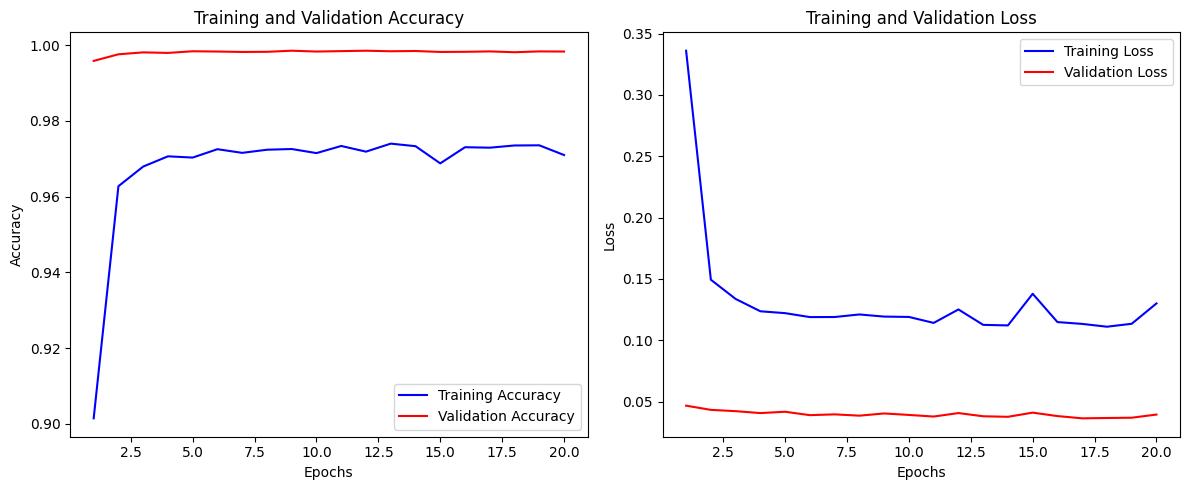

In [ ]:
# Function to plot training and validation trends
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss over epochs.

    Parameters:
        history (History object): The training history returned by model.fit().
    """
    # Extract metrics
    acc = history.history.get('accuracy', None)
    val_acc = history.history.get('val_accuracy', None)
    loss = history.history.get('loss', None)
    val_loss = history.history.get('val_loss', None)

    epochs = range(1, len(loss) + 1)

    # Plot accuracy
    if acc and val_acc:
        plt.figure(figsize=(12, 5))

        # Accuracy subplot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'b-', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Plot loss
    if loss and val_loss:
        # Loss subplot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'b-', label='Training Loss')
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function with the history object
plot_training_history(history)


#**Custom Metrics and Confusion Matrix with Predictions**

861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Precision: 0.9980
Recall: 0.9980
F1 Score: 0.9979


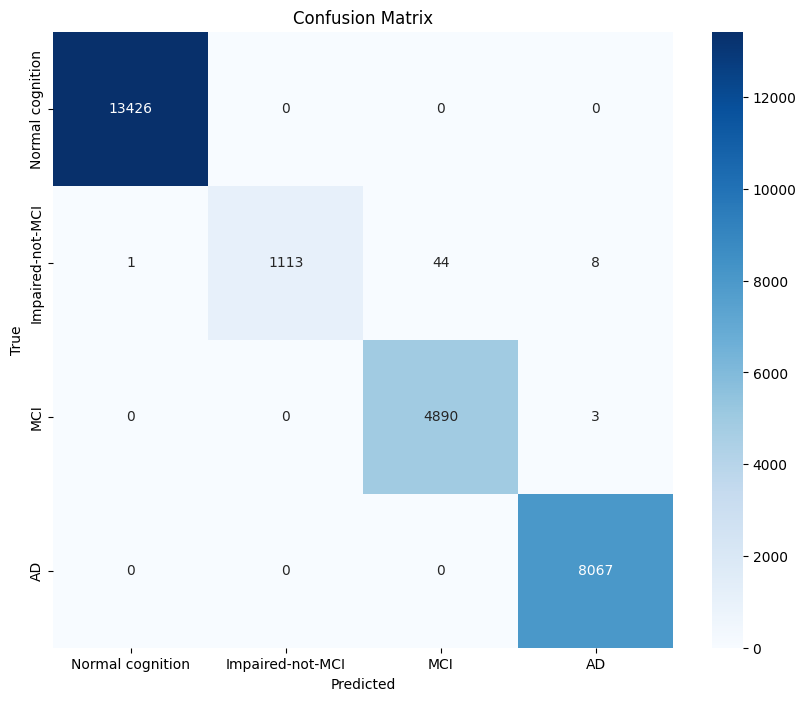

In [ ]:
# Define class names corresponding to the mapped values in the target column
# Example: Replace the values below with the actual class names in your dataset
class_names = [ 'Normal cognition', 'Impaired-not-MCI', 'MCI', 'AD']  # Replace with your actual feature names

# Get predictions
y_pred_probs = model.predict(test_generator, steps=steps_per_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate additional metrics

# Acessess y_test_seq to confirm it matches generator output
precision = precision_score(y_test_seq[:len(y_pred)], y_pred, average='weighted')
recall = recall_score(y_test_seq[:len(y_pred)], y_pred, average='weighted')
f1 = f1_score(y_test_seq[:len(y_pred)], y_pred, average='weighted')
cm = confusion_matrix(y_test_seq[:len(y_pred)], y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix Plot with feature names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save('Hybrid_LSTM&Feedforward.keras')